# About
Notebook simulating [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life).

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, animation, rc
from matplotlib.ticker import MultipleLocator, NullFormatter
from PIL import Image
from tqdm.notebook import tqdm

# Game Tick
Conway's game of life has the following 3 rules:
- Any live cell with two or three live neighbours survives.
- Any dead cell with three live neighbours becomes a live cell.
- All other live cells die in the next generation. Similarly, all other dead cells stay dead.

Every game tick every cell in the grid is checked against the 3 rules and a new
grid is created.

In [2]:
class ConwaysGame:
    """Conway's Game of Life class which provides generator for iterating ticks."""
    
    def __init__(self, start: np.ndarray, num_ticks: int):
        self._length = int(num_ticks)
        self._grid = start.copy()
    
    def __len__(self):
        return self._length
    
    @staticmethod
    def game_tick(grid: np.ndarray) -> np.ndarray:
        """Calculate next game grid for Conway's game of life."""
        new_grid = np.zeros_like(grid)
        for y in range(grid.shape[0]):
            for x in range(grid.shape[1]):
                curr = grid[y, x]
                grid_sum = np.sum(grid[y-1:y+2, x-1:x+2])
                if curr == 0 and grid_sum == 3:
                    # Dead becomes alive if 3 neighbours are alive
                    new_grid[y, x] = 1
                elif curr == 1 and (grid_sum - 1) in (2, 3):
                    # Alive stays alive if 2/3 neighbours are alive,
                    # subtracting 1 because current cell is 1
                    new_grid[y, x] = 1
        return new_grid

    def __iter__(self):
        """Generator to loop through number of ticks for game."""
        yield 0, self._grid
        for i in range(1, self._length + 1):
            self._grid = self.game_tick(self._grid)
            yield i, self._grid
            
    @property
    def grid(self):
        return self._grid

# Plotting Class
Class for plotting Conway's Game with matplotlib.

In [3]:
class PlotConway:
    """Class to manage creating the initial figure and updating it."""
    
    TITLE = "Conway's Game of Life"
    TITLE_FONT = {"fontsize": "xx-large"}
    
    def __init__(self, game: ConwaysGame):
        self.game = game
        self._init_figure()
        
    def _init_figure(self):
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.95)
        # Setup grid and remove axis ticks
        self.ax.grid(True, which="both", color="white", linestyle="-")
        self.ax.tick_params(bottom=False, left=False)
        self.ax.xaxis.set_major_locator(MultipleLocator(1))
        self.ax.xaxis.set_major_formatter(NullFormatter())
        self.ax.yaxis.set_major_locator(MultipleLocator(1))
        self.ax.yaxis.set_major_formatter(NullFormatter())
        self.ax.set_title(f"{self.TITLE} - initial grid", self.TITLE_FONT)
        # Create initial plot with custom blue/green colormap
        cmap = colors.ListedColormap(["#4287f5", "#46e050"])
        norm = colors.BoundaryNorm([0, .5, 1], cmap.N)
        self.image = self.ax.imshow(
            self.game.grid,
            aspect="equal",
            cmap=cmap,
            extent=(0, self.game.grid.shape[0], self.game.grid.shape[1], 0)
        )
    
    def _update(self, frame):
        i, grid = frame
        self.image.set_data(grid)
        self.ax.set_title(f"{self.TITLE} - tick {i}", self.TITLE_FONT)
        return (self.image,)
    
    def animate(self, interval: int=1000):
        """Create animation for the given game."""
        pbar = tqdm(
            self.game,
            total=len(self.game),
            desc="Generating game",
            dynamic_ncols=True,
            initial=1,
        )
        return animation.FuncAnimation(
            self.fig,
            self._update,
            frames=pbar,
            interval=interval,
            blit=True,
            repeat=False,
        )

# Initial Grid
Creating the starting grid for the game.

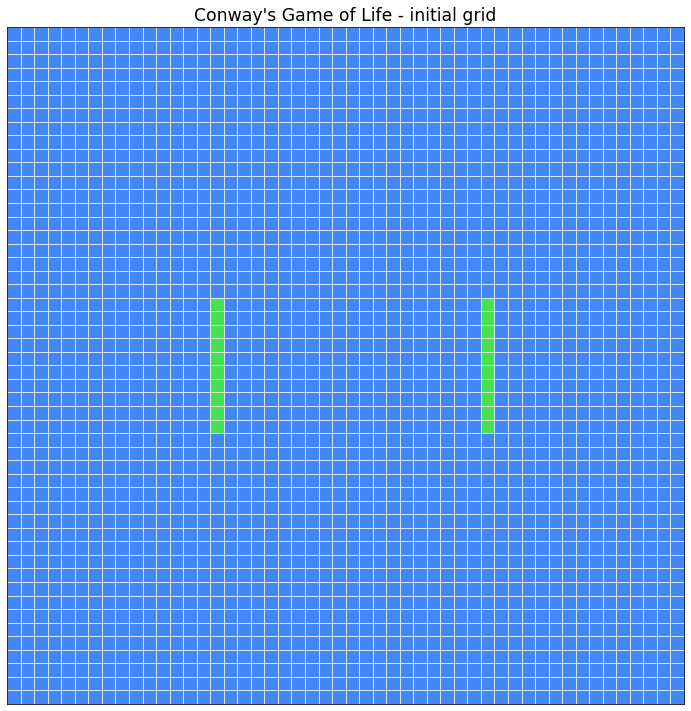

In [4]:
# Create initial grid
N = 50
init_grid = np.zeros((N, N))
init_grid[20:30, 15] = 1
init_grid[20:30, 35] = 1

# Create figure with initial grid
game1 = ConwaysGame(init_grid, 100)
conway_plot = PlotConway(game1)
plt.show()

# Playing Game
Iterating through N ticks in the game.

In [5]:
rc("animation", html="html5")
anim = conway_plot.animate()
display(anim)

# Random Game
Create a random initial grid based on [Perlin noise](https://en.wikipedia.org/wiki/Perlin_noise). The perlin noise algorithm below is taken from [StackOverflow](https://stackoverflow.com/a/42154921).

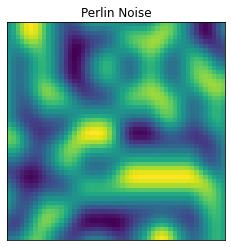

In [6]:
# Perlin noise function from https://stackoverflow.com/a/42154921
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0, 5, 50, endpoint=False)
x,y = np.meshgrid(lin, lin) # FIX3: I thought I had to invert x and y here but it was a mistake

fig, ax = plt.subplots()
ax.tick_params(bottom=False, left=False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.imshow(perlin(x, y, seed=np.random.randint(100)), origin='upper')
ax.set_title("Perlin Noise")
plt.show()

Seed is: 455560319


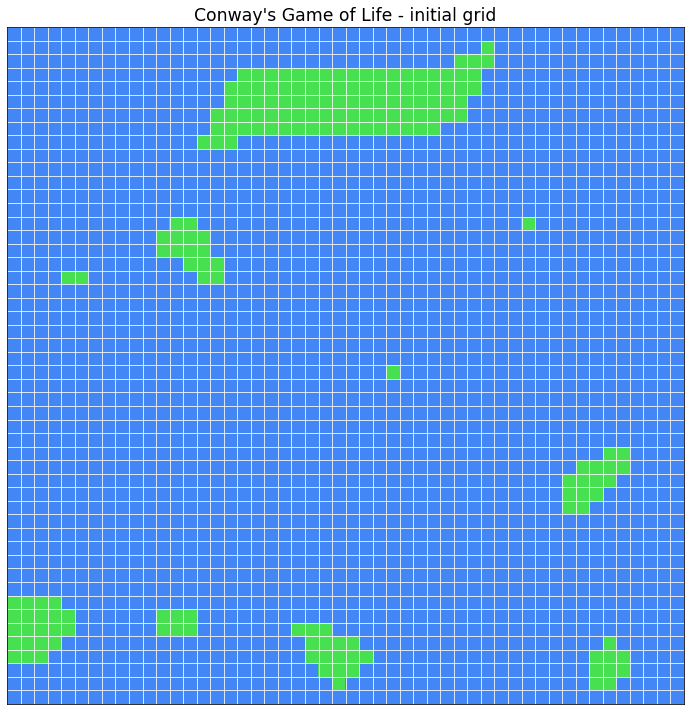

In [7]:
THRESHOLD = .3
SEED = 455560319
print(f"Seed is: {SEED}")
lin = np.linspace(0, 5, 50)
x, y = np.meshgrid(lin, lin)
random_grid = perlin(x, y, seed=SEED)
random_grid = (random_grid > THRESHOLD).astype(int)

random_game = ConwaysGame(random_grid, 100)
random_plot = PlotConway(random_game)
plt.show()

In [8]:
display(random_plot.animate())

# Initial Grid from Image
Reading grids from images, using some interesting patterns.

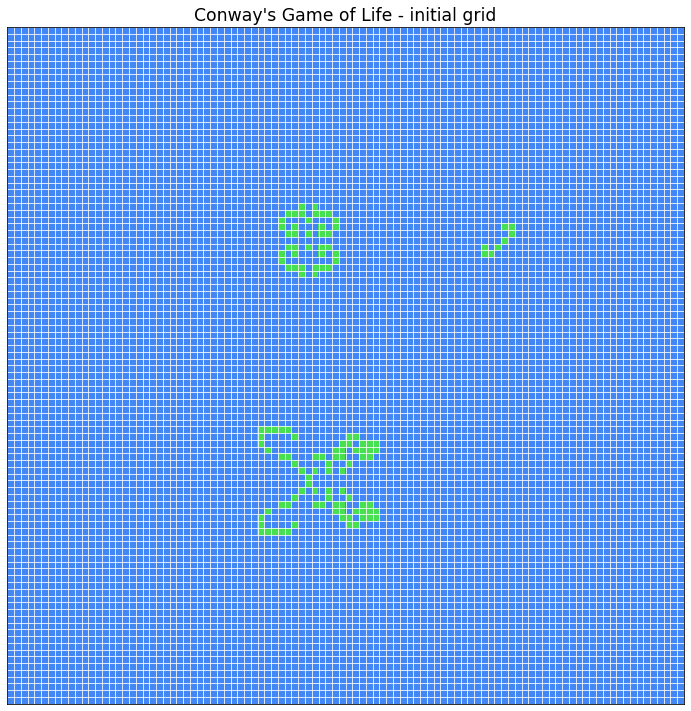

In [9]:
img_path = Path("../images/conway_interesting_patterns.png")

with Image.open(img_path) as im:
    image = im.convert("1")
initial_grid = (~np.array(image)).astype(int)
    
image_game = ConwaysGame(initial_grid, 100)
plot_image = PlotConway(image_game)
plt.show()

In [10]:
display(plot_image.animate())